In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from scipy import stats
import seaborn as sns
from functools import reduce
pd.options.mode.chained_assignment = None 
from statistics import mean
from profile_generation import *
from plotting import *
import warnings
warnings.simplefilter('ignore', np.RankWarning)
from scipy.optimize import curve_fit
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from openpyxl import load_workbook

C:\Users\tshibei\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Patient #117 has insufficient/<3 predictions (1 predictions) (for linear)!
Patient #117 has insufficient/<3 predictions (0 predictions) (for quadratic)!
Patient #121 has insufficient unique dose-response pairs for calibration (for quad)!
Patient #126 has insufficient unique dose-response pairs for calibration (for quad)!
Patient #130 has insufficient/<3 predictions (2 predictions) (for linear)!
Patient #130 has insufficient/<3 predictions (1 predictions) (for quadratic)!
Patient #133 has insufficient/<3 predictions (0 predictions) (for linear)!
Patient #133 has insufficient unique dose-response pairs for calibration (for quad)!
Patients to exclude for linear methods: ['117', '130', '133']
Patients to exclude for quad methods: ['117', '121', '126', '130', '133']
fail to reject null hypothesis, assume normal
count    13.000000
mean     23.356829
std      17.981665
min       0.000000
25%      12.121212
50%      16.666667
75%      36.000000
max      53.846154
Name: perc, dtype: float64
fai

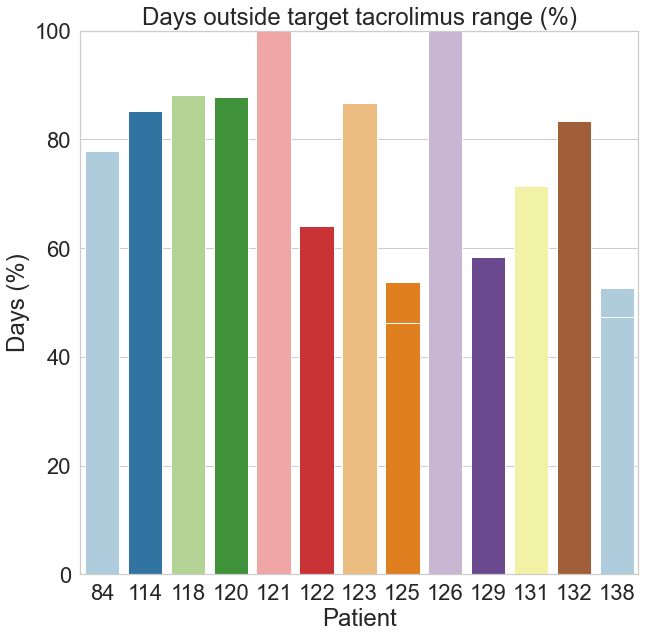

In [4]:
# %%capture cap --no-stderr

# Profile Generation

input_file = 'Retrospective Liver Transplant Data.xlsx'
rows_to_skip = 17

# Get list of patients/sheet names
list_of_patients = get_sheet_names(input_file)

# Define lists
list_of_patient_df = []
list_of_cal_pred_df = []
list_of_result_df = []
patients_to_exclude_linear = []
patients_to_exclude_quad = []

for patient in list_of_patients:
    
    # Create and clean patient dataframe        
    df = pd.read_excel(input_file, sheet_name=patient, skiprows=rows_to_skip)
    df = clean_data(df, patient)
    df = keep_ideal_data(df, patient, list_of_patient_df)
        
    # Select data for calibration and efficacy-driven dosing
    cal_pred_linear, patients_to_exclude_linear = cal_pred_data(df, patient, patients_to_exclude_linear, 1)
    cal_pred_quad, patients_to_exclude_quad = cal_pred_data(df, patient, patients_to_exclude_quad, 2)
    
    # Keep patients with sufficient dose-response pairs and predictions for each method
    cal_pred, list_of_cal_pred_df = keep_target_patients(patient, patients_to_exclude_linear, patients_to_exclude_quad, 
                                                     cal_pred_linear, cal_pred_quad, list_of_cal_pred_df)   
    
    # Apply methods
    list_of_result_df = apply_methods(cal_pred, patient, patients_to_exclude_linear, patients_to_exclude_quad,
              cal_pred_linear, cal_pred_quad, list_of_result_df)

# Print patients to exclude        
patients_to_exclude_linear = sorted(set(patients_to_exclude_linear))
patients_to_exclude_quad = sorted(set(patients_to_exclude_quad))
print(f"Patients to exclude for linear methods: {patients_to_exclude_linear}")
print(f"Patients to exclude for quad methods: {patients_to_exclude_quad}")

# Join dataframes from individual patients
df = pd.concat(list_of_patient_df)
df.patient = df.patient.apply(int)
df.reset_index(inplace=True, drop=True)
cal_pred = pd.concat(list_of_cal_pred_df)
cal_pred.patient = cal_pred.patient.apply(int)
result_df = pd.concat(list_of_result_df)
result_df = format_result_df(cal_pred, result_df)

# Export output and dataframes
# with open('output.txt', 'w') as f:
#     f.write(cap.stdout)
    
with pd.ExcelWriter('output.xlsx') as writer:
    df.to_excel(writer, sheet_name='clean', index=False)
    cal_pred.to_excel(writer, sheet_name='calibration_and_efficacy_driven', index=False)
    result_df.to_excel(writer, sheet_name='result', index=False)

# Plotting
# perc_days_within_target_tac(result_df)
# perc_days_outside_target_tac(result_df)
# median_perc_within_acc_dev(result_df)
# can_benefit(result_df)
# modified_TTR(result_df)